# 第一步：处理数据

先解压zip，分别读取数据


In [15]:
import zipfile
train_zip_file = "/home/ly/miniconda3/envs/shiwei/data/语音识别/train_data.zip"
test_zip_file = "/home/ly/miniconda3/envs/shiwei/data/语音识别/test_data.zip"

with zipfile.ZipFile(train_zip_file, "r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile(test_zip_file, "r") as zip_ref:
    zip_ref.extractall()
    
print("解压完成")

解压完成


In [16]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from d2l import torch as d2l
from sklearn.preprocessing import StandardScaler

首先查看数据集，发现有两大问题需要解决
- 给训练集按照文件夹名称打标签
- 给不定长的数据集进行同长度处理

## 打标签

先处理训练集，将按照文件夹的名称将训练集打入label，暂存列表train_data_list与train_label_list

In [17]:
label_mapping = {'language_0': 0, 'language_1': 1}
train_data_list = []
train_label_list = []

for root, dirs, files in os.walk('./train_data'):
    for file_name in files:
        if file_name.endswith('.npy'):
            file_path = os.path.join(root, file_name)
            folder_name = os.path.basename(root)
            label = label_mapping.get(folder_name, -1)  # 默认为-1，表示未知标签          
            if label != -1:
                data = np.load(file_path)
                train_data_list.append(data)
                train_label_list.append(label)

读入测试集，暂存列表test_data_list

In [18]:
test_data_list = []

for root, dirs, files in os.walk('./test_data'):
    for file_name in files:
        if file_name.endswith('.npy'):
            file_path = os.path.join(root, file_name)
            data = np.load(file_path)
            test_data_list.append(data)

In [19]:
(len(train_data_list), len(train_label_list), len(test_data_list),)

(4000, 4000, 2000)

## 处理变长长度

接下里处理变长长度，将其变为统一长度
暂存所有的变长长度，找到90%分位数，确定**90%为阈值**
- 大于90%阈值，截取
- 小于90%阈值，补0

In [20]:
data_list = train_data_list + test_data_list
lengths = [data.shape[0] for data in data_list]
percentile_length = int(np.percentile(lengths, 90))
percentile_length

395

In [21]:
new_data_list=[]
for data in data_list:
    if data.shape[0] < percentile_length:
      padding = np.zeros((percentile_length - data.shape[0], data.shape[1]), dtype=data.dtype)
      data_padded = np.vstack((data, padding))
    else:
      data_padded = data[:percentile_length, :]
    new_data_list.append(data_padded)
train_data_list = new_data_list[:4000]
test_data_list = new_data_list[4000:]

## 数据标准化与分割数据集

In [22]:
scaler = StandardScaler()
standardized_trains = [scaler.fit_transform(x) for x in train_data_list]
standardized_tests = [scaler.fit_transform(x) for x in test_data_list]

将数据变为张量便于后面计算，存储在GPU上

In [23]:
train_features = [torch.tensor(train,dtype=torch.float32, device='cuda:0') for train in standardized_trains]
#对于分类任务，需要标签数据是整数类型（通常是 torch.long）。如果标签数据是浮点数（torch.float），就会出现这个错误。
train_labels = [torch.tensor(label, dtype=torch.long, device='cuda:0') for label in train_label_list]
test_features= [torch.tensor(test,dtype=torch.float32) for test in standardized_tests]

#在PyTorch中，卷积层期望输入数据的形状为 [batch_size, channels, height, width]。如果您有一个 [4000, 395, 80] 的张量，这意味着您有4000个样本，每个样本的大小为395x80。这里缺少通道维度。在图像处理中，如果您的数据是灰度图像，您仍然需要添加通道维度，即使它只有一个通道。
train_features = torch.stack(train_features).to(torch.device('cuda:0')).unsqueeze(1)
train_labels = torch.stack(train_labels).to(torch.device('cuda:0'))
test_features = torch.stack(test_features).unsqueeze(1)

train_dataset = TensorDataset(train_features, train_labels)

分割训练集和验证集，按照8：2的比例

In [24]:
# 分割为训练集和验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 训练模型
- 目前的训练集和测试集的特征格式均为torch.float32格式，标签格式为torch.long，尺寸均为**(395,80)**
- 维度不大，建议选取的训练模型可以是MLP或者CNN
- 本人选取**深度学习经典模型CNN中的VGG算法**

In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # 先尝试batch_size=128
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_features, batch_size=128, shuffle=False)

In [26]:
demo = next(iter(train_loader))
demo[0].shape

torch.Size([128, 1, 395, 80])

设置了**三个VGG块**
- 一块是单卷积核5\*5卷积，两块是单卷积核3\*3卷积
- 总共是三个卷积，三个全连接层，是VGG6
- 每次经过池化层，尺寸减半

In [27]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(6, 16, kernel_size=3, stride=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(), nn.Linear(1408, 512), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)).cuda(0)

此处用于打印层数，方便后面调参使用

In [29]:
X = torch.rand(size=(1, 1, 395, 80), dtype=torch.float32).cuda(0)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 196, 38])
ReLU output shape: 	 torch.Size([1, 6, 196, 38])
MaxPool2d output shape: 	 torch.Size([1, 6, 97, 18])
Conv2d output shape: 	 torch.Size([1, 16, 95, 16])
ReLU output shape: 	 torch.Size([1, 16, 95, 16])
MaxPool2d output shape: 	 torch.Size([1, 16, 47, 7])
Conv2d output shape: 	 torch.Size([1, 32, 45, 5])
ReLU output shape: 	 torch.Size([1, 32, 45, 5])
MaxPool2d output shape: 	 torch.Size([1, 32, 22, 2])
Flatten output shape: 	 torch.Size([1, 1408])
Linear output shape: 	 torch.Size([1, 512])
ReLU output shape: 	 torch.Size([1, 512])
Dropout output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 128])
ReLU output shape: 	 torch.Size([1, 128])
Dropout output shape: 	 torch.Size([1, 128])
Linear output shape: 	 torch.Size([1, 2])


In [30]:
def train(net, train_loader, test_loader, num_epochs, lr): #训练过程以及可视化
    """用GPU训练模型，模型使用Adam，损失函数是交叉熵"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_loader)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_loader):
            timer.start()
            optimizer.zero_grad() 
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_loader)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

loss 0.018, train acc 0.996, test acc 0.955
38301.9 examples/sec


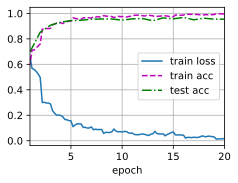

In [31]:
lr, num_epochs= 0.001, 20
train(net, train_loader, val_loader, num_epochs, lr)